### 9-1.  (밸류 + 퀄리티 + 모멘텀)퀀트 & Daily and Weekly Windows Momentum

In [1]:
import pandas as pd
import numpy as np

#  차트 설정
%matplotlib inline
import matplotlib.pyplot as plt

### Momentum 함수

In [2]:
def 주별수익(data):
    result = data/data.shift(1)
    return result

def 절대모멘텀(data,month):
    # shift를 사용하여 원화는 달의 수익률을 구한다
    # 당월주가 > n 개월 전 주가(n개월 모멘텀 > 0) --> 주식매수
    # 당월주가 < n 개월 전 주가(n개월 모멘텀 < 0) --> 주식매도
    result = np.where(data/data.shift(month)>1,1,0)
    return result

def CAGR(data):
    y = data.index.year.unique()
    result = (data[-1]/data[0])**(1/len(y))-1
    return np.round(result,4)

def MDD(data):
    window = len(data)

    # Calculate the max drawdown in the past window days for each day in the series.
    # Use min_periods=1 if you want to let the first 252 days data have an expanding window
    Roll_Max = data.rolling(window, min_periods=1).max()
    Roll_Max.rename("Roll_Max", inplace=True)
    Drawdown = data/Roll_Max - 1.0
    Drawdown.rename("Drawdown", inplace=True)

    # Next we calculate the minimum (negative) daily drawdown in that window.
    # Again, use min_periods=1 if you want to allow the expanding window
    Max_Drawdown = Drawdown.rolling(window, min_periods=1).min()
    Max_Drawdown.rename("Max_Drawdown", inplace=True)
    
    return np.round(Drawdown,4), np.round(Max_Drawdown,4)

def 주12평균모멘텀(data):
    # shift를 사용하여 원화는 달의 수익률을 구한다
    # 당월주가 > n 개월 전 주가(n개월 모멘텀 > 0) --> 주식매수
    # 당월주가 < n 개월 전 주가(n개월 모멘텀 < 0) --> 주식매도
    result = 0
    for i in range(1,13):
        result += np.where(data/data.shift(i)>1,1,0) 
    result = np.round(result/12,2)
    # 평균스코어 매매시 밴치마크 지수를 너무 쫓아가지 못함. 특정 점수 이상은 '1', 즉 전부 들어가는 방안에 고민이 필요함.
    # result[result>0.5] = 1
    return result

### MACD 함수

In [3]:
# EMA(Exponential Moving Average) : 지수이동평균
def EMA(close, timeperiod):  
    # k : smoothing constant
    k = 2/(1+timeperiod) 
    close = close.dropna()
    ema = pd.Series(index=close.index)
    ema[timeperiod-1] = close.iloc[0:timeperiod].sum() / timeperiod
    for i in range(timeperiod,len(close)):
        ema[i] = close[i]*k + ema[i-1] * (1-k)
    return ema

# MACD 구하기
def MACD(close, fastperiod=12, slowperiod=26, signalperiod=9):
    macd = EMA(close, fastperiod) - EMA(close, slowperiod)
    macd_signal = EMA(macd, signalperiod)
    macd_osc = macd - macd_signal
    df = pd.concat([macd, macd_signal, macd_osc],axis=1)
    df.columns = ['MACD','Signal','Oscillator']
    return df

# Main

### 퀀트종목에서 순위내 종목 리스트 만들기

In [4]:
# 파일 읽어오기
mvc = pd.read_csv("밸류퀄리티모멘텀_종합순위.csv",sep=",",encoding="euc-kr",engine="python")

# 오름차순으로 정렬
mvc.sort_values(["total_rank"],ascending=True,inplace=True)

# 코드번호 앞의 "A"문자 제거
import re
code = mvc["코드번호"].apply(lambda x:re.sub("A","",x))

### 종목 data 가져오기

In [5]:
close = pd.read_csv("20190126 KRX전체종목Colse가격Data.csv",sep=",",encoding="utf-8", engine="python")
close.index = pd.to_datetime(close["Date"])  # to_datetime으로 datetime type으로 index 지정
del close["Date"]

# 퀀트 순위 종목의 close 수합하여 새로운 데이타 조합을 만듬
data = pd.Series()  # concat할 빈 시리즈 생성
for i in range(0,100):
    cl = close[code[i]]
    data = pd.concat([data,cl], axis=1)
# 사용하지 않는 컬럼"0" 삭제
data.drop([0],axis=1, inplace=True)

In [6]:
data.head()

,005930,000660,068270,051910,005380,017670,207940,005490,015760,028260,...,017800,016360,253450,008560,011780,000100,004170,007310,030000,010060
2010-01-04,16180,24100,15327,224000,119000,170000,NaN,612000,34250,NaN,...,43874,63247,NaN,1157,20850,147634,352531,149000,12476,215000
2010-01-05,16440,23350,15524,222500,110000,168500,NaN,618000,34050,NaN,...,44026,64290,NaN,1139,20650,148473,340057,148000,12275,213500
2010-01-06,16820,24550,15868,222500,111000,169000,NaN,612000,34000,NaN,...,43950,64764,NaN,1135,22000,150150,341370,150000,12135,216500
2010-01-07,16260,24400,15524,213000,106000,171500,NaN,606000,33800,NaN,...,44026,64290,NaN,1148,22400,148891,340714,148500,11994,218500
2010-01-08,16420,24650,15722,216000,106000,169500,NaN,606000,33800,NaN,...,43723,66566,NaN,1180,21550,147634,338088,151000,11673,227000


### 사전 Daily MACD, ma5, ma20 데이타 만들기

In [10]:
close = data["051910"]
# Day 데이타 가공하기
# 주가 / 이동평균 / MACD
day = close
ma5 = day.rolling(window=5).mean()
ma20 = day.rolling(window=20).mean()
macd = MACD(close)
macd["MACD"].iloc[0] = 0  # MACD 첫 nan값을 "0"으로 세팅하여 시작 time을 Close 그래프와 맞춤

#  절대모멘텀 / MACD
momentum12 = pd.Series(주12평균모멘텀(close), index=close.index)
macd2 = MACD(momentum12,12,24)
macd2['MACD'].iloc[0] = 0  # MACD 첫 nan값을 "0"으로 세팅하여 시작 time을 Close 그래프와 맞춤

# 절대모멘텀 윈도우 24일 값 구하기, 장 시간동안 모멘텀 스코어 유효성을 검증하기 위해 사용한다.
w24 = momentum12.rolling(window=24).mean()
w24.iloc[0] = 0  # MACD 첫 nan값을 "0"으로 세팅하여 시작 time을 Close 그래프와 맞춤

day = pd.concat([day, ma5, ma20, macd["MACD"], macd["Signal"],macd2["MACD"], macd2["Signal"],momentum12, w24], axis=1)
day.columns = ["Close","ma5","ma20","MACD","Signal","MACD2","Signal2","momentum12","window24"]

# Week 데이타 가공하기
# 주가 / 이동평균
week = close.resample("W-FRI")._upsample(None).interpolate()
ma5 = week.rolling(window=5).mean()
ma20 = week.rolling(window=20).mean()
week = pd.concat([week,ma5,ma20], axis=1)
week.columns = ["Close","ma5","ma20"]

### 구간 데이타 만들기

In [11]:
day = day["2017":]
week = week["2017":]

### Test

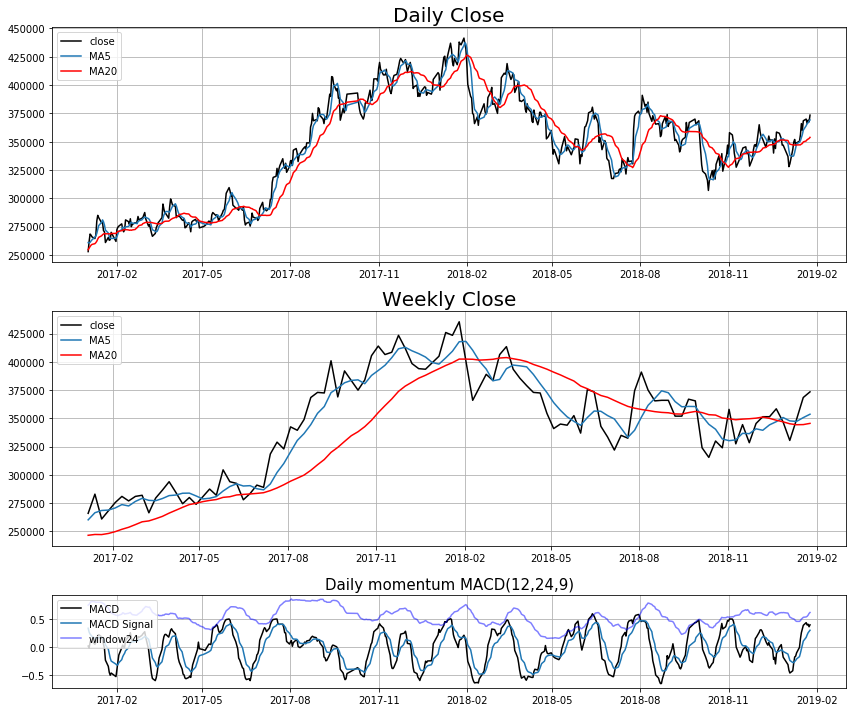

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline


# 차트 레이아웃을 설정합니다.
fig = plt.figure(figsize=(12,10))
ax_main = plt.subplot2grid((5, 1), (0, 0), rowspan=2)
ax_sub = plt.subplot2grid((5, 1), (2, 0), rowspan=2)
ax_sub2 = plt.subplot2grid((5, 1), (4, 0))

# Day 메인차트를 그립니다.
ax_main.set_title('Daily Close',fontsize=20)
ax_main.plot(day["Close"], color="Black", label='close')
ax_main.plot(day["ma5"], label='MA5')
ax_main.plot(day["ma20"], color="Red", label='MA20')
ax_main.grid(True)
ax_main.legend(loc=2)

# Week 메인차트를 그립니다.
ax_sub.set_title('Weekly Close',fontsize=20)
ax_sub.plot(week["Close"], color="Black", label='close')
ax_sub.plot(week["ma5"], label='MA5')
ax_sub.plot(week["ma20"], color="Red", label='MA20')
ax_sub.grid(True)
ax_sub.legend(loc=2)

# ax_sub2 에 MACD 오실레이터를 bar 차트로 출력합니다.
ax_sub2.set_title('Daily momentum MACD(12,24,9)',fontsize=15)
ax_sub2.plot(day['MACD2']*4, color="Black", label='MACD')  # 곱하기 4는 그래프 크기를 확대위한 값
ax_sub2.plot(day['Signal2']*4, label='MACD Signal')  # 곱하기 4는 그래프 크기를 확대위한 값
ax_sub2.plot(day['window24'], alpha=0.5, color="Blue", label='window24')
ax_sub2.grid(True)
ax_sub2.legend(loc=2)

# 차트끼리 충돌을 방지합니다.
plt.tight_layout()
plt.show()